# Convolutional Neural Network (CNN) Project
Raquel Colares Santos

## Phase 2 - Transfer Learning

## Objective

The dataset used on this project is the animal_10, which contains 10 classes for animal classification.
The classification has around 28K animal images and the 10 classes are dog, cat, horse, spyder, butterfly, chicken, sheep, cow, squirrel, elephant.

The objective of this project is to apply the CNN concepts learned creating 2 CNN's architecture, training and evaluating the model, and after analyse 2 models using transfer learning using the same conditions as the previous ones created.  

## Data Preprocessing

In [1]:
# Installing the split-folders
!pip install split-folders

In [2]:
# Installing the torchinfo
!pip install -q torchinfo

In [3]:
# Libraries
import torch
from torch import nn
import zipfile
from pathlib import Path
import splitfolders
import numpy as np
from torch.utils.data import WeightedRandomSampler
from torchvision import transforms
from torchvision import datasets
import os
from torch.utils.data import DataLoader
from timeit import default_timer as timer
import matplotlib.pyplot as plt
from torchinfo import summary
import torchvision

####   Setting the Device

On this project it will be used the GPU "cuda" for making the CNN more efficient since it has intensive computations.

In [4]:
# Setting the device
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

####   Getting the data


The data was saved on my google drive, and connected to this jupyter, but in a zip format. This code was used to unzip the files that contains the images of the animals that will be used in the CNN.

In [5]:
# Setting the image path
data_path = Path("Project_CNN/")
image_path = data_path / "Images"

# Unziping the file
with zipfile.ZipFile("/content/drive/MyDrive/Colab Notebooks/Project_CNN/Images/animal_10.zip", "r") as zip_ref:
    print("Unzipping animals...")
    zip_ref.extractall(image_path)

Unzipping animals...


#### Translating the folders' name

The folders name are in other language, so the first thing to is to do is to translate the folders to English.

In [6]:
# Translating the folders
translate_path = Path("/content/Project_CNN/Images/translate.py")
f = open(translate_path, "r")
folder_dict = f.readline()
f.close()
exec(folder_dict)

os.chdir("/content/Project_CNN/Images/raw-img")
all_subdirs = []
for d in os.listdir("."):
    if os.path.isdir(d):
        all_subdirs.append(d)

for dir in all_subdirs:
  if dir in translate.keys():
    os.rename("/content/Project_CNN/Images/raw-img/" + dir, "/content/Project_CNN/Images/raw-img/" + translate.get(dir))

#### Splitting in Train and Test folders

In [7]:
# Splitting the folders in train and test
splitfolders.ratio("/content/Project_CNN/Images/raw-img", output="/content/Project_CNN/Images/animal_10", seed=42, ratio=(0.8, 0.0, 0.2)) # train, validation, test

Copying files: 26179 files [00:04, 5473.36 files/s]


##  CNN  models

### AlexNet

The architecture of the AlexNet consists of total 8 layers, which five are convolutional layers, followed by three fully-connected layers and a softmax at the end.
On first, second and fifth convolutional layers, have a max pooling layer, with stride of 2 and kernel size 3. It refers to the paper "ImageNet Classification with Deep Convolutional Neural Networks" that can be seen on the references of this project.

The AlexNet architecture was chosen to be used on this project because it's simple, effective, it is available for the transfer learning part, and it is a good fit for the size of my dataset.

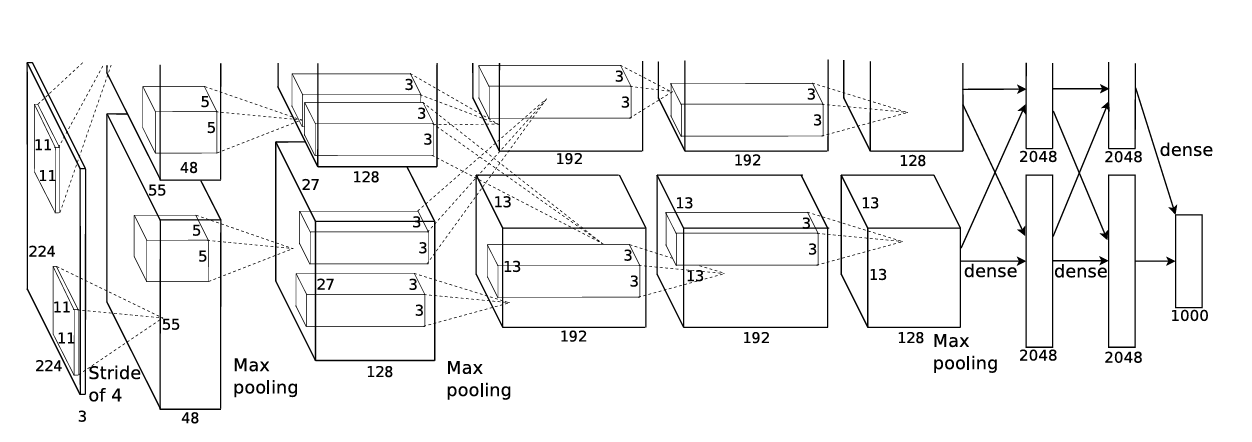

* Setting the Transfer Learning model

On the part B of this project, instead of creating a model from scratch I will use the transfer learning model, a model already pretrained for one task that will be reused for another task, to improve the performance of the model.

First, I set the pretrained weights for the transfer learning model, using the `torchvision.models.AlexNet_Weights.DEFAULT`, where the `.DEFAULT` represents the best and recent available weights.

And after I will set `torchvision.models.alexnet(weights=weights)` to create the model with the pretrained weights.


In [8]:
# Setting the pretrained weights
weights = torchvision.models.AlexNet_Weights.DEFAULT
weights

AlexNet_Weights.IMAGENET1K_V1

In [9]:
# Get the transform to be compatible with AlexNet's pretrained weights
alexnet_transform = weights.transforms()
alexnet_transform

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [10]:
# Setting the model with pretrained weights
model_3 = torchvision.models.alexnet(weights=weights).to(device)
model_3

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 158MB/s]


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

* Freezing the base layers

The `summary()` function from the library `torchinfo` of PyTorch shows a detailed summary of the CNN model.

We can notice that in the last column shows if the layers are trainable, and when I imported the model it was `True` meaning the layer was unfreezed. Then I froze them with `param.requires_grad = False` for preventing the weights of the pre-trained layers from being updated during training. This is optional but a good practice when the dataset for example is small to avoid overfitting, and it also reduces computational cost with fewer gradients to calculate.

In [11]:
# Printing a summary using torchinfo
summary(model=model_3,
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
AlexNet (AlexNet)                        [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                  [32, 3, 224, 224]    [32, 256, 6, 6]      --                   True
│    └─Conv2d (0)                        [32, 3, 224, 224]    [32, 64, 55, 55]     23,296               True
│    └─ReLU (1)                          [32, 64, 55, 55]     [32, 64, 55, 55]     --                   --
│    └─MaxPool2d (2)                     [32, 64, 55, 55]     [32, 64, 27, 27]     --                   --
│    └─Conv2d (3)                        [32, 64, 27, 27]     [32, 192, 27, 27]    307,392              True
│    └─ReLU (4)                          [32, 192, 27, 27]    [32, 192, 27, 27]    --                   --
│    └─MaxPool2d (5)                     [32, 192, 27, 27]    [32, 192, 13, 13]    --                   --
│    └─Conv2d (6)     

In [12]:
# Freezing the base layers
for param in model_3.features.parameters():
    param.requires_grad = False

In [13]:
# Printing a summary using torchinfo, to verify the modification made
summary(model=model_3,
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
AlexNet (AlexNet)                        [32, 3, 224, 224]    [32, 1000]           --                   Partial
├─Sequential (features)                  [32, 3, 224, 224]    [32, 256, 6, 6]      --                   False
│    └─Conv2d (0)                        [32, 3, 224, 224]    [32, 64, 55, 55]     (23,296)             False
│    └─ReLU (1)                          [32, 64, 55, 55]     [32, 64, 55, 55]     --                   --
│    └─MaxPool2d (2)                     [32, 64, 55, 55]     [32, 64, 27, 27]     --                   --
│    └─Conv2d (3)                        [32, 64, 27, 27]     [32, 192, 27, 27]    (307,392)            False
│    └─ReLU (4)                          [32, 192, 27, 27]    [32, 192, 27, 27]    --                   --
│    └─MaxPool2d (5)                     [32, 192, 27, 27]    [32, 192, 13, 13]    --                   --
│    └─Conv2d (6

* Adapting the model for 10 classes

The AlexNet model was original trained with 1000 output classes as we can notice on the previous summary, and for this dataset is 10 classes so I adapted the last layer as shown bellow.

In [14]:
NUM_CLASSES = 10

# Adapting the model from 1000 to 10 classes
model_3.classifier[6] = nn.Linear(4096, NUM_CLASSES).to(device)
model_3

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

* Creating the dataloader

In [15]:
train_dir = "/content/Project_CNN/Images/animal_10/train"
test_dir = "/content/Project_CNN/Images/animal_10/test"

train_data = datasets.ImageFolder(root=train_dir, transform=alexnet_transform)
test_data = datasets.ImageFolder(root=test_dir, transform=alexnet_transform)

# Setting the batch size and number of workers
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

# Creating the DataLoader's
train_dataloader = DataLoader(train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=NUM_WORKERS)

test_dataloader = DataLoader(test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False,
                             num_workers=NUM_WORKERS)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7fd5a78deb30>,
 <torch.utils.data.dataloader.DataLoader at 0x7fd5a95868f0>)

* Establishing the Loss and Optimizer

In [16]:
LEARNING_RATE = 0.001

# Loss
criterion = nn.CrossEntropyLoss()
# Optimizer
optimizer = torch.optim.SGD(model_3.parameters(), lr=LEARNING_RATE, weight_decay = 0.005, momentum=0.9)

* Training and evaluating the model

In [18]:
NUM_EPOCHS = 20

# Setting the seed
torch.manual_seed(42)
# Starting the timer
start_time = timer()

# Creating lists for putting the tensor value in a list format to plot later
train_loss_plot = []
test_loss_plot = []
train_acc_plot = []
test_acc_plot = []


for epoch in range(NUM_EPOCHS):
    # Training
    train_loss = 0
    train_acc = 0
    for batch, (X, y) in enumerate(train_dataloader):
        model_3.train()
        X = X.to(device)
        y = y.to(device)
        ## Forward pass
        y_pred = model_3(X)
        ## Calculating the loss
        loss = criterion(y_pred, y)
        train_loss += loss
        ## Optimizer zero grad
        optimizer.zero_grad()
        ## Backward
        loss.backward()
        ## Optimizer
        optimizer.step()
        ## Calculate and accumulate accuracy metrics across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)
    ## Adjusting metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(train_dataloader)
    train_acc = train_acc / len(train_dataloader)

    # Testing
    test_loss = 0
    test_acc = 0
    model_3.eval()
    with torch.inference_mode():
        for X, y in test_dataloader:
            X = X.to(device)
            y = y.to(device)
            ## Forward pass
            test_pred = model_3(X)
            ## Calculating the loss
            test_loss += criterion(test_pred, y) # accumulatively add up the loss per epoch
            ## Calculate and accumulate accuracy
            test_pred_labels = test_pred.argmax(dim=1)
            test_acc += (test_pred_labels == y).sum().item()/len(test_pred_labels)
    ## Adjusting metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(test_dataloader)
    test_acc = test_acc / len(test_dataloader)

    print(f"Epoch: {epoch} | Train loss: {train_loss:.5f} |  Train acc: {train_acc:.2f} | Test loss: {test_loss:.5f} | Test acc: {test_acc:.2f}\n")
    train_loss_plot.append(train_loss.item())
    test_loss_plot.append(test_loss.item())
    train_acc_plot.append(train_acc)
    test_acc_plot.append(test_acc)

# Ending the timer
end_time = timer()
# Printing the total time
print(f"Total training time: {end_time-start_time:.3f} seconds")

Epoch: 0 | Train loss: 0.37137 |  Train acc: 0.88 | Test loss: 0.27439 | Test acc: 0.91

Epoch: 1 | Train loss: 0.22005 |  Train acc: 0.93 | Test loss: 0.24820 | Test acc: 0.92

Epoch: 2 | Train loss: 0.17181 |  Train acc: 0.94 | Test loss: 0.24679 | Test acc: 0.92

Epoch: 3 | Train loss: 0.13890 |  Train acc: 0.95 | Test loss: 0.23600 | Test acc: 0.92

Epoch: 4 | Train loss: 0.11506 |  Train acc: 0.96 | Test loss: 0.22419 | Test acc: 0.93

Epoch: 5 | Train loss: 0.09634 |  Train acc: 0.97 | Test loss: 0.22335 | Test acc: 0.93

Epoch: 6 | Train loss: 0.08390 |  Train acc: 0.97 | Test loss: 0.22308 | Test acc: 0.93

Epoch: 7 | Train loss: 0.07213 |  Train acc: 0.98 | Test loss: 0.21971 | Test acc: 0.93

Epoch: 8 | Train loss: 0.06611 |  Train acc: 0.98 | Test loss: 0.22187 | Test acc: 0.93

Epoch: 9 | Train loss: 0.06101 |  Train acc: 0.98 | Test loss: 0.22544 | Test acc: 0.93

Epoch: 10 | Train loss: 0.05398 |  Train acc: 0.99 | Test loss: 0.22103 | Test acc: 0.93

Epoch: 11 | Train lo

* Plotting the Loss curve

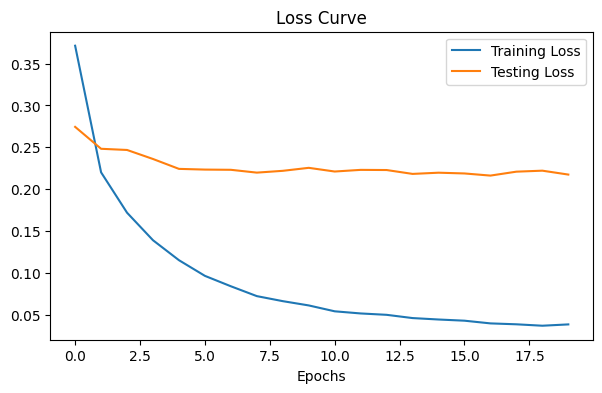

In [19]:
# Plotting the Loss Curve
epochs_train_loss = range(len(train_loss_plot))
epochs_test_loss = range(len(test_loss_plot))
plt.figure(figsize=(7,4))
plt.plot(epochs_train_loss, train_loss_plot, label="Training Loss")
plt.plot(epochs_test_loss, test_loss_plot, label="Testing Loss")
plt.xlabel("Epochs")
plt.title("Loss Curve")
plt.legend()
plt.show();

* Plotting the Accuracy

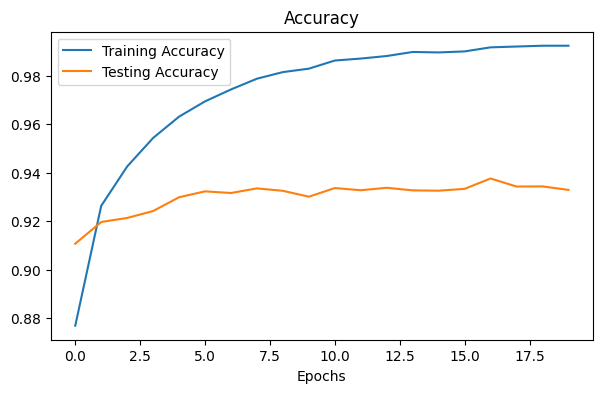

In [20]:
# Plotting the Accuracy
epochs_train_acc = range(len(train_acc_plot))
epochs_test_acc = range(len(test_acc_plot))
plt.figure(figsize=(7,4))
plt.plot(epochs_train_acc, train_acc_plot, label="Training Accuracy")
plt.plot(epochs_test_acc, test_acc_plot, label="Testing Accuracy")
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.legend();

* Analysing the model AlexNet with Transfer Learning

On the model with transfer learning, I got 99% accuracy for training and 93% accuracy for testing with 20 epochs. Analysing the values obtained for accuracy and loss, even them being good values, it is possible to see on the plottings above that the AlexNet model is overfitting, the model is not generalizing well for this dataset with that amount of epochs, the model is memorizing the training data instead of generalizing well to unseen data. We can notice also that good values can be obtained for fewer epochs, so on this case one alternative was to train with less epochs.

* Saving the model

In [21]:
torch.save(model_3.state_dict(),"/content/drive/MyDrive/Colab Notebooks/Project_CNN/Models/AlexNet_transfer_learning.pth")

### VGG16

The architecture of the VGG16 consists of sixteen layers total, which thirteen are convolutional layers, followed by three fully connected layers. Between the second, fourth, seventh, tenth, and thirteen layer, it has a max pooling layer for downsampling. It refers to the paper "Very Deep Convolutional Networks for Large-Scale Image Recognition" that can be seen on the references of this project.

The VGG16 architecture was chosen to be used on this project because it's effective, it is available for the transfer learning part, it's a deep architecture which means that it can captures more features, as a trade-off, I am aware it takes more time and it's more computational expensive if compared with the last model.


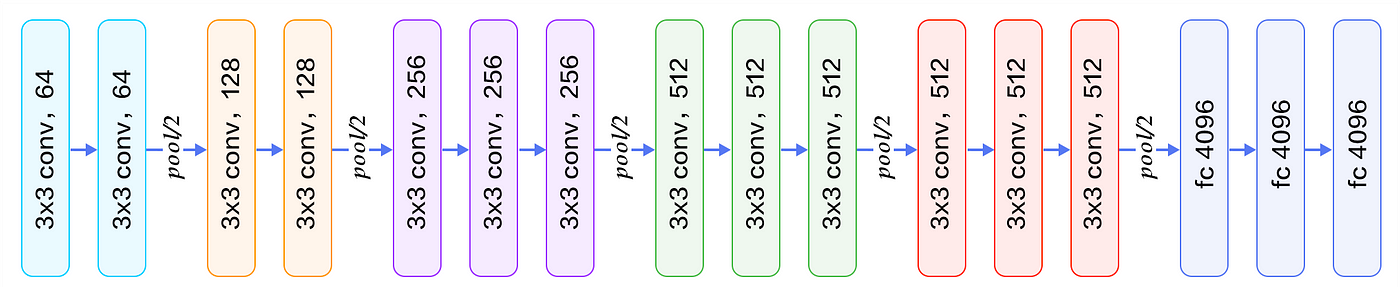

* Setting the Transfer Learning model

On the part B of this project, instead of creating a model from scratch I will use the transfer learning model, a model already pretrained for one task that will be reused for another task, to improve the performance of the model.

First, I set the pretrained weights for the transfer learning model, using the `torchvision.models.VGG16_Weights.DEFAULT`, where the `.DEFAULT` represents the best and recent available weights.

And after I will set `torchvision.models.vgg16(weights=weights)` to create the model with the pretrained weights.

In [22]:
# Setting the pretrained weights
weights = torchvision.models.VGG16_Weights.DEFAULT
weights

VGG16_Weights.IMAGENET1K_V1

In [23]:
# Get the transform to be compatible with VGG16 pretrained weights
vgg16_transform = weights.transforms()
vgg16_transform

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [24]:
# Setting the model with pretrained weights
model_4 = torchvision.models.vgg16(weights=weights).to(device)
model_4

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:04<00:00, 124MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

* Freezing the base layers

The `summary()` function from the library `torchinfo` of PyTorch shows a detailed summary of the CNN model.

We can notice that in the last column shows if the layers are trainable, and when I imported the model it was `True` meaning the layer was unfreezed. Then I froze them with `param.requires_grad = False` for preventing the weights of the pre-trained layers from being updated during training. This is optional but a good practice when the dataset for example is small to avoid overfitting, and it also reduces computational cost with fewer gradients to calculate.

In [25]:
# Printing a summary using torchinfo
summary(model=model_4,
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
VGG (VGG)                                [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                  [32, 3, 224, 224]    [32, 512, 7, 7]      --                   True
│    └─Conv2d (0)                        [32, 3, 224, 224]    [32, 64, 224, 224]   1,792                True
│    └─ReLU (1)                          [32, 64, 224, 224]   [32, 64, 224, 224]   --                   --
│    └─Conv2d (2)                        [32, 64, 224, 224]   [32, 64, 224, 224]   36,928               True
│    └─ReLU (3)                          [32, 64, 224, 224]   [32, 64, 224, 224]   --                   --
│    └─MaxPool2d (4)                     [32, 64, 224, 224]   [32, 64, 112, 112]   --                   --
│    └─Conv2d (5)                        [32, 64, 112, 112]   [32, 128, 112, 112]  73,856               True
│    └─ReLU (6)     

In [26]:
# Freezing the base layers
for param in model_4.features.parameters():
    param.requires_grad = False

In [27]:
# Printing a summary using torchinfo, to verify the modification made
summary(model=model_4,
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
VGG (VGG)                                [32, 3, 224, 224]    [32, 1000]           --                   Partial
├─Sequential (features)                  [32, 3, 224, 224]    [32, 512, 7, 7]      --                   False
│    └─Conv2d (0)                        [32, 3, 224, 224]    [32, 64, 224, 224]   (1,792)              False
│    └─ReLU (1)                          [32, 64, 224, 224]   [32, 64, 224, 224]   --                   --
│    └─Conv2d (2)                        [32, 64, 224, 224]   [32, 64, 224, 224]   (36,928)             False
│    └─ReLU (3)                          [32, 64, 224, 224]   [32, 64, 224, 224]   --                   --
│    └─MaxPool2d (4)                     [32, 64, 224, 224]   [32, 64, 112, 112]   --                   --
│    └─Conv2d (5)                        [32, 64, 112, 112]   [32, 128, 112, 112]  (73,856)             False
│    └─ReLU (

* Adapting the model for 10 classes

The VGG16 model was original trained with 1000 output classes as we can notice on the previous summary, and for this dataset is 10 classes so I adapted the last layer as shown bellow.

In [28]:
NUM_CLASSES = 10

# Adapting the model from 1000 to 10 classes
model_4.classifier[6] = nn.Linear(4096, NUM_CLASSES).to(device)
model_4

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

*   Creating the dataloader

In [29]:
train_dir = "/content/Project_CNN/Images/animal_10/train"
test_dir = "/content/Project_CNN/Images/animal_10/test"

train_data = datasets.ImageFolder(root=train_dir, transform=vgg16_transform)
test_data = datasets.ImageFolder(root=test_dir, transform=vgg16_transform)

# Setting the batch size and number of workers
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

# Creating the DataLoader's
train_dataloader = DataLoader(train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=NUM_WORKERS)

test_dataloader = DataLoader(test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False,
                             num_workers=NUM_WORKERS)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7fd5a7651630>,
 <torch.utils.data.dataloader.DataLoader at 0x7fd5a76534c0>)

* Establishing the Loss and Optimizer

In [30]:
LEARNING_RATE = 0.001

# Loss
criterion = nn.CrossEntropyLoss()
# Optimizer
optimizer = torch.optim.SGD(model_4.parameters(), lr=LEARNING_RATE,  weight_decay = 0.005, momentum=0.9)

* Training and evaluating the model

In [31]:
NUM_EPOCHS = 20

# Setting the seed
torch.manual_seed(42)
# Starting the timer
start_time = timer()

# Creating lists for putting the tensor value in a list format to plot later
train_loss_plot = []
test_loss_plot = []
train_acc_plot = []
test_acc_plot = []

for epoch in range(NUM_EPOCHS):
    # Training
    train_loss = 0
    train_acc = 0
    for batch, (X, y) in enumerate(train_dataloader):
        model_4.train()
        X = X.to(device)
        y = y.to(device)
        ## Forward pass
        y_pred = model_4(X)
        ## Calculating the loss
        loss = criterion(y_pred, y)
        train_loss += loss
        ## Optimizer zero grad
        optimizer.zero_grad()
        ## Backward
        loss.backward()
        ## Optimizer
        optimizer.step()
        ## Calculate and accumulate accuracy metrics across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)
    ## Adjusting metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(train_dataloader)
    train_acc = train_acc / len(train_dataloader)

    # Testing
    test_loss = 0
    test_acc = 0
    model_4.eval()
    with torch.inference_mode():
        for X, y in test_dataloader:
            X = X.to(device)
            y = y.to(device)
            ## Forward pass
            test_pred = model_4(X)
            ## Calculating the loss
            test_loss += criterion(test_pred, y) # accumulatively add up the loss per epoch
            ## Calculate and accumulate accuracy
            test_pred_labels = test_pred.argmax(dim=1)
            test_acc += (test_pred_labels == y).sum().item()/len(test_pred_labels)
    ## Adjusting metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(test_dataloader)
    test_acc = test_acc / len(test_dataloader)

    print(f"Epoch: {epoch} | Train loss: {train_loss:.5f} |  Train acc: {train_acc:.2f} | Test loss: {test_loss:.5f} | Test acc: {test_acc:.2f}\n")
    train_loss_plot.append(train_loss.item())
    test_loss_plot.append(test_loss.item())
    train_acc_plot.append(train_acc)
    test_acc_plot.append(test_acc)

# Ending the timer
end_time = timer()
# Printing the total time
print(f"Total training time: {end_time-start_time:.3f} seconds")

Epoch: 0 | Train loss: 0.22350 |  Train acc: 0.93 | Test loss: 0.14608 | Test acc: 0.96

Epoch: 1 | Train loss: 0.10985 |  Train acc: 0.96 | Test loss: 0.13922 | Test acc: 0.96

Epoch: 2 | Train loss: 0.07599 |  Train acc: 0.98 | Test loss: 0.13583 | Test acc: 0.96

Epoch: 3 | Train loss: 0.05610 |  Train acc: 0.98 | Test loss: 0.13383 | Test acc: 0.96

Epoch: 4 | Train loss: 0.03989 |  Train acc: 0.99 | Test loss: 0.13771 | Test acc: 0.96

Epoch: 5 | Train loss: 0.03087 |  Train acc: 0.99 | Test loss: 0.13897 | Test acc: 0.96

Epoch: 6 | Train loss: 0.02477 |  Train acc: 0.99 | Test loss: 0.13981 | Test acc: 0.97

Epoch: 7 | Train loss: 0.01863 |  Train acc: 1.00 | Test loss: 0.14025 | Test acc: 0.96

Epoch: 8 | Train loss: 0.01607 |  Train acc: 1.00 | Test loss: 0.14382 | Test acc: 0.96

Epoch: 9 | Train loss: 0.01514 |  Train acc: 1.00 | Test loss: 0.14349 | Test acc: 0.96

Epoch: 10 | Train loss: 0.01238 |  Train acc: 1.00 | Test loss: 0.14370 | Test acc: 0.96

Epoch: 11 | Train lo

* Plotting the Loss curve

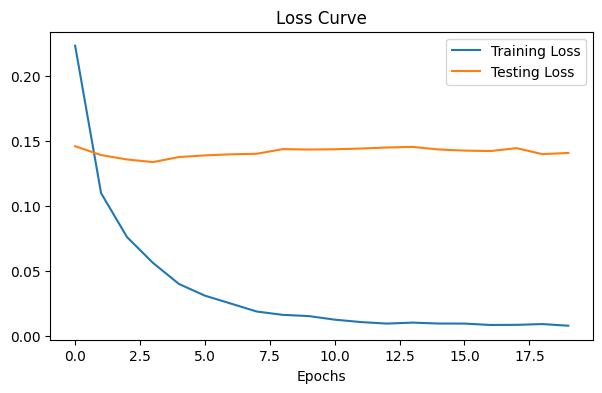

In [32]:
# Ploting the Loss Curve
epochs_train = range(len(train_loss_plot))
epochs_test = range(len(test_loss_plot))
plt.figure(figsize=(7,4))
plt.plot(epochs_train, train_loss_plot, label='Training Loss')
plt.plot(epochs_test, test_loss_plot, label='Testing Loss')
plt.xlabel('Epochs')
plt.title('Loss Curve')
plt.legend()
plt.show();

* Plotting the Accuracy

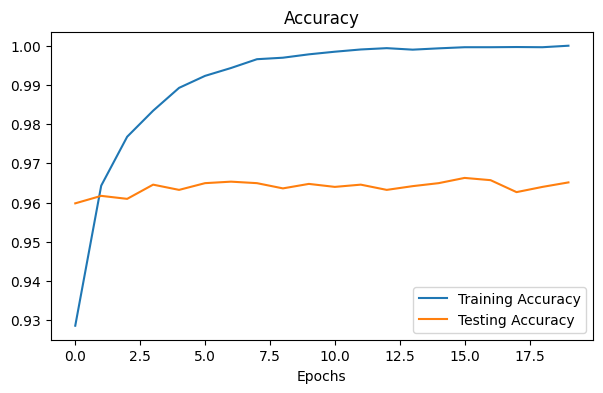

In [33]:
# Plotting the Accuracy
epochs_train_acc = range(len(train_acc_plot))
epochs_test_acc = range(len(test_acc_plot))
plt.figure(figsize=(7,4))
plt.plot(epochs_train_acc, train_acc_plot, label="Training Accuracy")
plt.plot(epochs_test_acc, test_acc_plot, label="Testing Accuracy")
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.legend();

* Analysing the model VGG16 with Transfer Learning

On the VGG16 model with transfer learning, I got 100% accuracy for training and 97% accuracy for testing with 20 epochs. Analysing the values obtained for accuracy and loss, even them being good values, it is possible to see on the plottings above that the VGG16 model is overfitting, the model is not generalizing well for this dataset with that amount of epochs, the model is memorizing the training data instead of generalizing well to unseen data. We can notice also that good values can be obtained for fewer epochs, so on this case one alternative was to train with less epochs.

* Saving the model

In [34]:
torch.save(model_4.state_dict(),"/content/drive/MyDrive/Colab Notebooks/Project_CNN/Models/VGG16_transfer_learning.pth")

## Analyzing the models created from scratch and the ones with transfer learning

Comparing all the four models, with and without transfer learning, we can observe that the models created from scratch generalized well after 20 epochs, but required more training and more time. While the models with transfer learning achieve a much higher accuracy for training and testing, even for fewer epochs, however by continuing training them, they overfit and didn't generalize well.

In conclusion, for this specifically dataset, by tunning your models, it is possible to get good results creating from scratch AlexNet and VGG16 but requiring more training. If the choice is to use tranfer learning, you can get higher accuracies in a smaller time and in a fewer epochs, but requires attention to don't overfit.



## References

https://pytorch.org/vision/stable/transforms.html

https://www.geeksforgeeks.org/how-to-normalize-images-in-pytorch/

https://pytorch.org/vision/stable/models.html#classification

https://papers.nips.cc/paper/2012/hash/c399862d3b9d6b76c8436e924a68c45b-Abstract.html

https://pytorch.org/vision/main/models/generated/torchvision.models.alexnet.html

https://arxiv.org/abs/1409.1556